In [1]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

from aind_vr_foraging_analysis.utils.parsing import data_access
from aind_vr_foraging_analysis.utils.plotting import plotting_friction_experiment as f

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='yellow'
odor_list_color = [color1, color2, color3, color4]

pdf_path = r'Z:\scratch\vr-foraging\sessions'
results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\experiments\batch 5 - learning\results'

color_dict_label = {'InterSite': '#808080',
    'InterPatch': '#b3b3b3', 
    'PatchZ': '#d95f02', 'PatchZB': '#d95f02', 
    'PatchB': '#d95f02','PatchA': '#7570b3', 
    'PatchC': '#1b9e77',
    'Alpha-pinene': '#1b9e77', 
    'Methyl Butyrate': '#7570b3', 
    'Amyl Acetate': '#d95f02', 
    'Fenchone': '#7570b3', 
    'patch_single': color1,
    'patch_delayed': color2,
    'patch_no_reward': color3,
     'S': color1,
    'D': color2,
    'N': color3,   
    '90': color1,
    '60': color2,
    '0': color3,
    }

label_dict = {**{
"InterSite": '#808080',
"InterPatch": '#b3b3b3'}, 
            **color_dict_label}
import os


In [2]:
# Function to assign codes
def get_condition_code(text):
    if 'delayed' in text:
        return 'D'
    elif 'single' in text:
        return 'S'
    elif 'no_reward' in text or 'noreward' in text:
        return 'N'
    else:
        return None

In [9]:
date_string = "2024-4-1"
mouse_list = ['754570','754579','754567','754580','754559','754560','754577',
              '754566','754571','754572','754573','754574','754575', 
              '754582','745302','745305','745301',
              
              '754574', '789914', '789915', '789923', '789917', 
               '789913', '789909', '789910', '789911', '789921', 
               '789918', '789919', '789907', '789903', '789925', 
               '789924', '789926', '789908']

sum_df = pd.DataFrame()
df = pd.DataFrame()
for mouse in mouse_list:
    session_paths = data_access.find_sessions_relative_to_date(
        mouse=mouse,
        date_string=date_string,
        when='on_or_after',
    )
    session_n = 0
    for session_path in session_paths:
        print(mouse, session_path)
        try:
            all_epochs, stream_data, data = data_access.load_session(
                session_path
            )
        except:
            print(f"Error loading {session_path.name}")
            continue
        
        stage = data['config'].streams.tasklogic_input.data['stage_name']
        
        all_epochs['mouse'] = mouse
        all_epochs['session'] = session_path.name[7:17]
        all_epochs['session_n'] = session_n
        all_epochs['stage'] = stage
        
        last_engaged_patch = all_epochs['patch_number'][all_epochs['skipped_count'] >= 5].min()
        if pd.isna(last_engaged_patch):
            last_engaged_patch = all_epochs['patch_number'].max()
        all_epochs['engaged'] = np.where(all_epochs['patch_number'] <= last_engaged_patch, 1, 0)
        session_n += 1
        
        all_epochs['patch_label'] = all_epochs['patch_label'].astype(str)
        all_epochs['s_patch_label'] = all_epochs['patch_label'].apply(get_condition_code)
        
        patch_total = all_epochs.groupby('s_patch_label')['patch_number'].nunique()

        visited_filter = (all_epochs.site_number == 0) & (all_epochs.is_choice == 1)
        patch_visited = all_epochs.loc[visited_filter].groupby('s_patch_label')['patch_number'].nunique()
        
        # Combine into one dataframe
        patch_df = pd.DataFrame({
            'patch_number': patch_total,
            'visited': patch_visited
        }).fillna(0)  # Fill NaNs for labels that were never visited

        patch_df['fraction_visited'] = patch_df['visited'] / patch_df['patch_number']
        patch_df['mouse'] = mouse
        patch_df['session'] = session_path.name[7:17]
        patch_df['session_n'] = session_n
        session_n += 1  
        sum_df = pd.concat([patch_df.reset_index(), sum_df])
        df = pd.concat([all_epochs, df])
        
df.reset_index(inplace=True)

754570 Z:\scratch\vr-foraging\data\754570\754570_20240823T104815
No reward sites found
Error loading 754570_20240823T104815
754570 Z:\scratch\vr-foraging\data\754570\754570_20240903T122712
Reward functions from software events
754570 Z:\scratch\vr-foraging\data\754570\754570_20240904T114053
Reward functions from software events
754570 Z:\scratch\vr-foraging\data\754570\754570_20240905T112958
Reward functions from software events
754570 Z:\scratch\vr-foraging\data\754570\754570_20240906T105852
Reward functions from software events
754570 Z:\scratch\vr-foraging\data\754570\754570_20240911T131919
Reward functions from software events
754570 Z:\scratch\vr-foraging\data\754570\754570_20240912T110112
Reward functions from software events
754570 Z:\scratch\vr-foraging\data\754570\754570_20240913T111333
Reward functions from software events
754570 Z:\scratch\vr-foraging\data\754570\754570_20240916T111512
Reward functions from software events
754570 Z:\scratch\vr-foraging\data\754570\754570_202

In [10]:
results_df = df.loc[df.site_number == 0].groupby([ 'mouse','session','patch_label']).is_choice.mean().reset_index() 

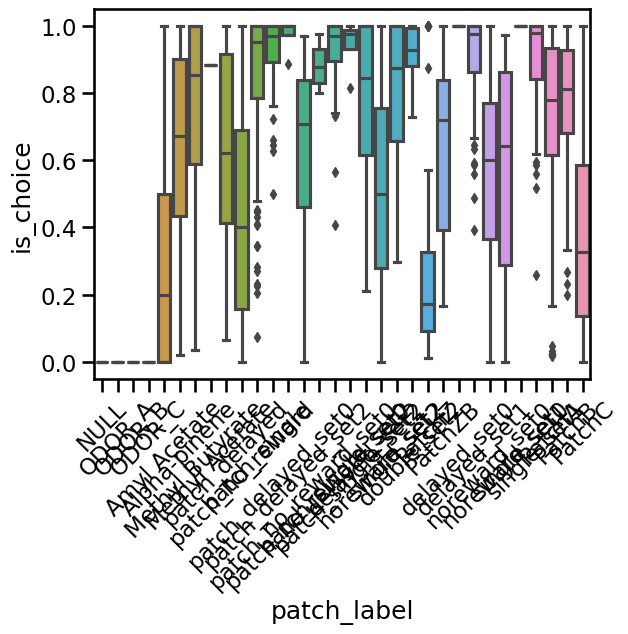

In [12]:
sns.boxplot(x='patch_label', y='is_choice', data=results_df)
plt.xticks(rotation=45);